In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns
import datetime
import copy

plt.style.use(['science','ieee'])
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
%ls ../results/eas-pstate-schedutil-balanced/xonotic

ls: cannot access '../results/eas-pstate-schedutil-balanced/xonotic': No such file or directory


In [3]:
# fields: scheduler, driver, governor, algorithm, game, configuration, run
# datas: turbostat, pcm, mangohud,

In [4]:
def to_float(list_: list[str]):
    return [float(i) for i in list_]

def parse_cores_data(list_):
    return [int(i) for i in list_[:4]] + [float(list_[4])]

def read_turbostat(file_path):
    with open(file_path) as file:
        content = file.readline()

        while not content.startswith('Core'):
            content = file.readline()

        content = content.strip().split('\t')
        header_cores, header_energy = content[:-3], content[-2:]

        turbostat_cores = []
        turbostat_energy = []
        i = 0 
        while content[0] == 'Core':   

            file.readline()

            content = file.readline().strip().split('\t')
            core_data, energy_data = content[:-2], content[-2:]
            turbostat_cores.append([i] + parse_cores_data(core_data))
            turbostat_energy.append([i] + to_float(energy_data))

            while content[-1] != header_energy[-1] and content[0] != '':
    #             print(content)
                turbostat_cores.append([i] + parse_cores_data(content))
                content = file.readline().strip().split('\t')
            i += 1

    turbostat_cores_df = pd.DataFrame(data=turbostat_cores, columns=['step']+header_cores)
    turbostat_energy_df = pd.DataFrame(data=turbostat_energy, columns=['step']+header_energy)

    power_watt = turbostat_energy_df.PkgWatt.mean()
    energy_j = turbostat_energy_df.PkgWatt.sum()
#     std_watt = turbostat_energy_df.PkgWatt.std()

    return [power_watt, energy_j]

In [5]:
def import_turbostat(path):
    format_ = "%y-%m-%d %H-%M-%S"
    header = ['run', 'power_watt', 'energy_j']
    datetime_list = []

    files = os.listdir(path)
    turbostat_files = list(filter(lambda x: x.startswith('turbostat'), files))

    for f in turbostat_files:
        splited_f = f.split('_')
        date = splited_f[1]
        time = splited_f[2][:8]
        res = {
            'datetime': datetime.datetime.strptime(f"{date} {time}", format_),
            'file': f
        }
        datetime_list.append(res)

    datetime_list = sorted(datetime_list, key=lambda x: x['datetime'])

    turbostat_list = [f['file'] for f in datetime_list]

    turbostat = []
    for key,f in enumerate(turbostat_list):
        turbostat.append([key] + read_turbostat(f'{path}/{f}'))

    turbostat_df = pd.DataFrame(data=turbostat, columns=header)

    turbostat_df_base = turbostat_df[turbostat_df['run'] % 2 == 0]
    turbostat_df_vals = turbostat_df[turbostat_df['run'] % 2 != 0]
    turbostat_df_base['run'] //= 2
    turbostat_df_vals['run'] //= 2
    turbostat_df_base = turbostat_df_base.set_index('run')
    turbostat_df_vals = turbostat_df_vals.set_index('run')

    turbostat_vals = turbostat_df_vals - turbostat_df_base


    power_std_watt = turbostat_vals.power_watt.std()
    power_mean_watt = turbostat_vals.power_watt.mean()
    power_error_percent = power_std_watt * 100 / power_mean_watt

    energy_std_j = turbostat_vals.energy_j.std()
    energy_mean_j = turbostat_vals.energy_j.mean()
    energy_error_percent = energy_std_j * 100 / energy_mean_j

    return [power_mean_watt, power_std_watt, power_error_percent, energy_mean_j, energy_std_j, energy_error_percent]

In [6]:
def import_cpuload(path, game):
    fps_files = list(filter(lambda x: x.startswith(game), os.listdir(path)))
    header = [
        'median_cpuload',
    ]
    data = []

    for key,fps_file in enumerate(fps_files):
        row = []
        fps = pd.read_csv(f"{path}/{fps_file}", skiprows=2)

        row.append(fps.cpu_load.median())

        data.append(row)

    fps_df = pd.DataFrame(data=data, columns=header)

    vals = fps_df.median()
    std = fps_df.median_cpuload.std()
    std_percent = std * 100 / vals.median_cpuload

    vals_ = vals.to_list()
    vals_.append(std_percent)
    headers = header.append('median_cpuload_error_percent')
    
    return vals_

In [7]:
def import_fps(path, game):
    fps_files = list(filter(lambda x: x.startswith(game), os.listdir(path)))
    header = [
        'median_fps',
        'median_fps_under_60',
        'mean_fps_under_60',
        'fps_jitter',
        'fps_tail_99',
        'fps_drop_60',
        'fps_drop_50',
        'fps_drop_40',
        'fps_drop_30',
        'fps_drop_60_percent',
        'fps_drop_50_percent',
        'fps_drop_40_percent',
        'fps_drop_30_percent',
    ]
    data = []

    for key,fps_file in enumerate(fps_files):
        row = []
        fps = pd.read_csv(f"{path}/{fps_file}", skiprows=2)

        row.append(fps.fps.median())
        u = fps.fps - 60

        row.append(u[u <= 0].abs().median())
        row.append(u[u <= 0].abs().mean())
        row.append(fps.fps.diff().abs().mean())
        row.append(fps.fps.quantile(.01))

        drops_60 = fps.fps[fps.fps <= 60]
        drops_50 = fps.fps[fps.fps <= 50]
        drops_40 = fps.fps[fps.fps <= 40]
        drops_30 = fps.fps[fps.fps <= 30]
        drops = [drops_60.count(), drops_50.count(), drops_40.count(), drops_30.count()]
        total = fps.fps.count()
        drops_percent = [i*100/total for i in drops]

        row = row + drops + drops_percent

        data.append(row)

    fps_df = pd.DataFrame(data=data, columns=header)

    vals = fps_df.median()
    std = fps_df.median_fps.std()
    std_percent = std * 100 / vals.median_fps

    vals_ = vals.to_list()
    vals_.append(std_percent)
    headers = header.append('median_fps_error_percent')
    
    return vals_

In [8]:
prefix = '../results'
evals = os.listdir('../results')

In [9]:
def get_head(game):
    if game == 'xonotic':
        return 'xono'
    if game == 'combat_master':
        return 'Combat'

In [10]:
data = []
for eval_ in evals:
    splited = eval_.split('-')
    games = os.listdir(f'{prefix}/{eval_}')
    header = {
        'scheduler': 'cfs_eas' if splited[0] == 'eas' else 'cfs',
        'driver': 'intel_pstate' if splited[1] == 'pstate' else 'cpu_freq',
        'governor': 'schedutil' if splited[1] != 'performance' else 'performance',
        'algorithm': splited[3],
        'path': f'{prefix}/{eval_}',
        'game': None,
        'cpu_config': None,
        'turbostat_data': None,
        'fps_data': None,
        'cpuload_data': None,
    }
    for game in games:
        header = copy.deepcopy(header)
        header['game'] = game
        cpu_configs = os.listdir(f'{prefix}/{eval_}/{game}')
        cpu_configs = list(filter(lambda x: 'base' not in x, cpu_configs))
        print(games, cpu_configs)
        for cpu_config in cpu_configs:
            header = copy.deepcopy(header)
            header['cpu_config'] = cpu_config
            path = f"{header['path']}/{game}/{cpu_config}"
            header['turbostat_data'] = import_turbostat(path)
            header['fps_data'] = import_fps(path, game=get_head(game))
            header['cpuload_data'] = import_cpuload(path, game=get_head(game))
#             print(header)
            data.append(header)

['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']
['combat_master', 'xonotic'] ['6P', '2P-4E', '3P-3E', '4P-2E']


In [11]:
keys = list(data[0].keys())
keys.remove('path')

In [12]:
datas = {}

In [13]:
header_fps = [
    'median_fps',
    'median_fps_under_60',
    'mean_fps_under_60',
    'fps_jitter',
    'fps_tail_99',
    'fps_drop_60',
    'fps_drop_50',
    'fps_drop_40',
    'fps_drop_30',
    'fps_drop_60_percent',
    'fps_drop_50_percent',
    'fps_drop_40_percent',
    'fps_drop_30_percent',
    'median_fps_error_percent'
]

header_cpuload = [
    'median_cpuload',
    'median_cpuload_error_percent',
]

header_turbostat = [
    'power_mean_watt',
    'power_std_watt', 
    'power_error_percent',
    'energy_mean_j', 
    'energy_std_j', 
    'energy_error_percent'
]

headers_data = [header_turbostat, header_fps, header_cpuload]
keys_data = keys[-3:]

dfs = []
for key in keys[:-3]:
    t = [val[key] for val in data]
    dfs.append(pd.DataFrame(data=t, columns=[key]))
    
for key, header in zip(keys_data, headers_data):
    t = [val[key] for val in data]
    dfs.append(pd.DataFrame(data=t, columns=header))

In [14]:
df = pd.concat(dfs, axis=1)

In [15]:
df.head()

,scheduler,driver,governor,algorithm,game,cpu_config,power_mean_watt,power_std_watt,power_error_percent,energy_mean_j,...,fps_drop_50,fps_drop_40,fps_drop_30,fps_drop_60_percent,fps_drop_50_percent,fps_drop_40_percent,fps_drop_30_percent,median_fps_error_percent,median_cpuload,median_cpuload_error_percent
0,cfs,intel_pstate,schedutil,powersave,combat_master,6P,9.639855,1.265849,13.131411,3277.062609,...,93.0,70.0,42.0,49.948031,0.538818,0.404858,0.243027,0.014309,17.81510,2.720767
1,cfs,intel_pstate,schedutil,powersave,combat_master,2P-4E,9.957785,0.182756,1.835310,3745.349000,...,121.0,47.0,28.0,50.025890,0.696243,0.271771,0.161197,0.030374,16.24370,0.649979
2,cfs,intel_pstate,schedutil,powersave,combat_master,3P-3E,9.482198,0.171390,1.807490,3600.263000,...,128.0,63.0,38.0,50.031819,0.739542,0.363951,0.219704,0.022343,18.66670,1.091420
3,cfs,intel_pstate,schedutil,powersave,combat_master,4P-2E,9.380277,0.384299,4.096881,3418.875714,...,107.0,67.0,42.0,49.985543,0.618426,0.387306,0.243577,0.029132,19.66870,1.681404
4,cfs,intel_pstate,schedutil,powersave,xonotic,6P,7.781662,0.134569,1.729311,2651.867500,...,314.0,126.5,65.0,49.748967,1.837117,0.739052,0.380062,0.031833,7.84641,1.459877


In [16]:
grouped_df = df.groupby(['game', 'scheduler', 'algorithm', 'cpu_config']).median(numeric_only=True)

In [17]:
type(df)

pandas.core.frame.DataFrame

In [18]:
head = [
    'scheduler',
    'driver',
    'governor',
    'algorithm',
    'game',
    'cpu_config'
]

In [19]:
def get_df(
    df: pd.core.frame.DataFrame, 
    scheduler=None, governor=None, 
    driver=None, algorithm=None, 
    game=None, cpu_config=None
):
    u = df.copy(deep=True)
    
    if scheduler is not None:
        u = u[u.scheduler == scheduler]
    if governor is not None:
        u = u[u.governor == governor]
    if driver is not None:
        u = u[u.driver == driver]
    if game is not None:
        u = u[u.game == game]
    if algorithm is not None:
        u = u[u.algorithm == algorithm]
    if cpu_config is not None:
        u = u[u.cpu_config == cpu_config]
    
    return u

In [20]:
u = get_df(df, scheduler='cfs', algorithm='performance', game='xonotic')

In [21]:
x = 'cpu_config'

In [38]:
values = ['power_mean_watt', 'energy_mean_j', 'median_fps', 'fps_drop_60_percent', 'fps_drop_50_percent', 'fps_tail_99', 'median_cpuload']

In [39]:
df.keys()

Index(['scheduler', 'driver', 'governor', 'algorithm', 'game', 'cpu_config',
       'power_mean_watt', 'power_std_watt', 'power_error_percent',
       'energy_mean_j', 'energy_std_j', 'energy_error_percent', 'median_fps',
       'median_fps_under_60', 'mean_fps_under_60', 'fps_jitter', 'fps_tail_99',
       'fps_drop_60', 'fps_drop_50', 'fps_drop_40', 'fps_drop_30',
       'fps_drop_60_percent', 'fps_drop_50_percent', 'fps_drop_40_percent',
       'fps_drop_30_percent', 'median_fps_error_percent', 'median_cpuload',
       'median_cpuload_error_percent'],
      dtype='object')

In [40]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 18})

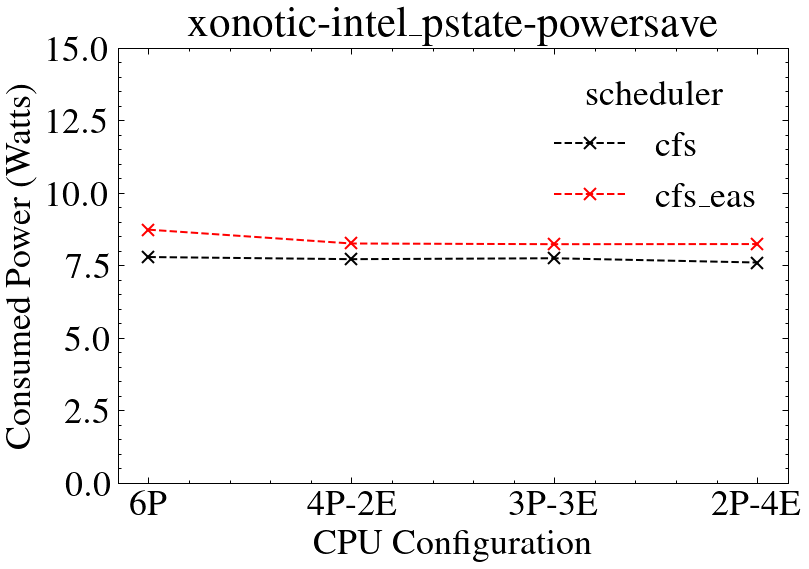

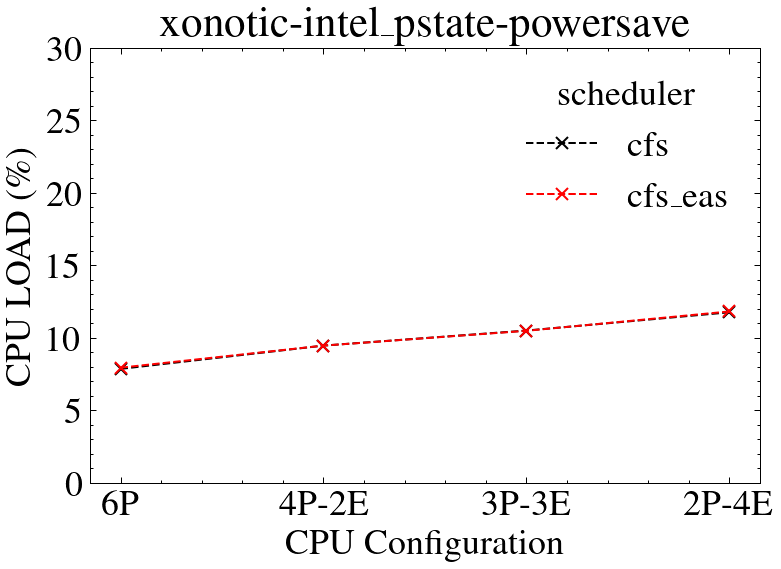

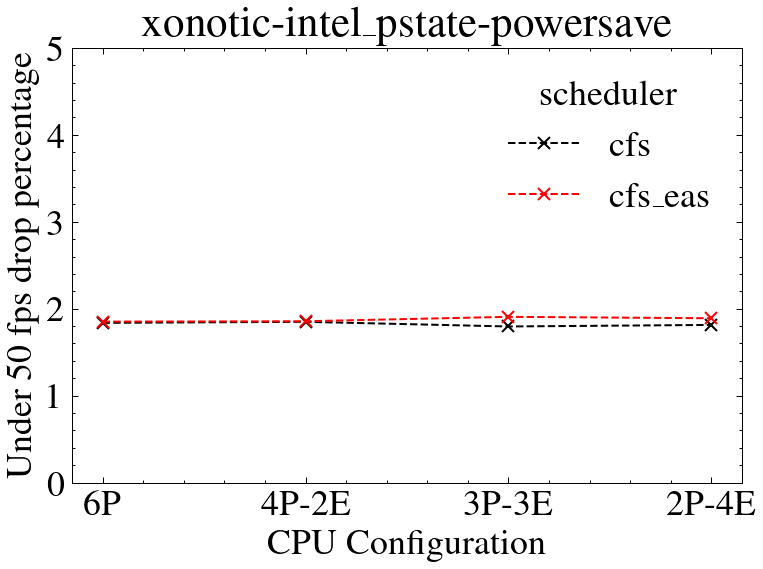

power gain
cpu_config
6P      -12.134218
4P-2E    -7.015022
3P-3E    -6.270010
2P-4E    -8.381915
dtype: float64

performance loss
cpu_config
6P      -0.778527
4P-2E   -0.345104
3P-3E   -6.176643
2P-4E   -4.221835
dtype: float64


In [64]:
game = 'xonotic'
algo = 'powersave'
df_ = get_df(df, game=game, algorithm=algo)


t = pd.pivot_table(df_, index=['cpu_config'], columns=['scheduler'], values=values).iloc[::-1]

t.plot.line(
    y='power_mean_watt', 
    xlabel='CPU Configuration', 
    ylabel='Consumed Power (Watts)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 15],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='median_cpuload', 
    xlabel='CPU Configuration', 
    ylabel='CPU LOAD (\%)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 30],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='fps_drop_50_percent', 
    xlabel='CPU Configuration', 
    ylabel='Under 50 fps drop percentage', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 5],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

print("power gain")
print((1 - t.power_mean_watt.cfs_eas / t.power_mean_watt.cfs)*100)
print("\nperformance loss")
print((1 - t.fps_drop_50_percent.cfs_eas / t.fps_drop_50_percent.cfs)*100)

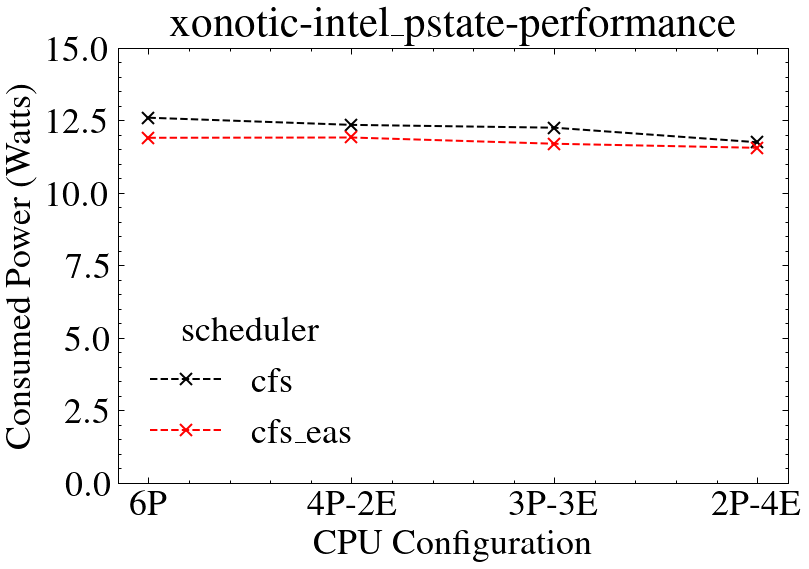

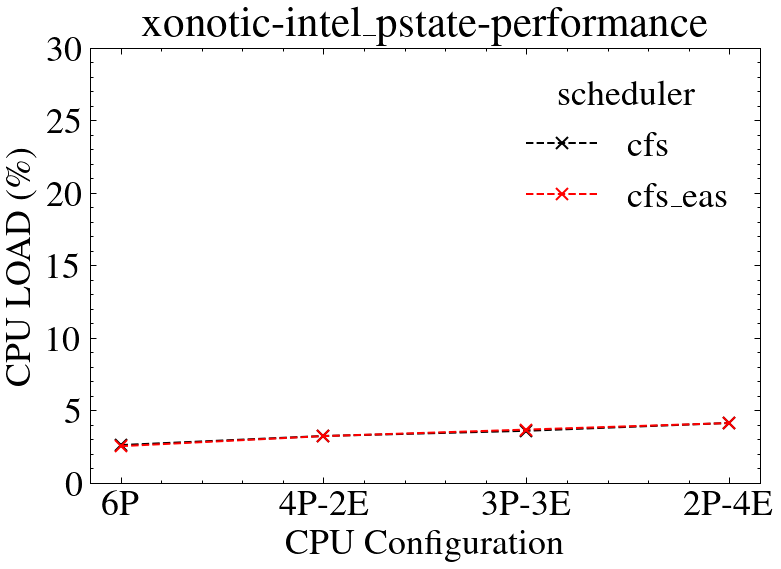

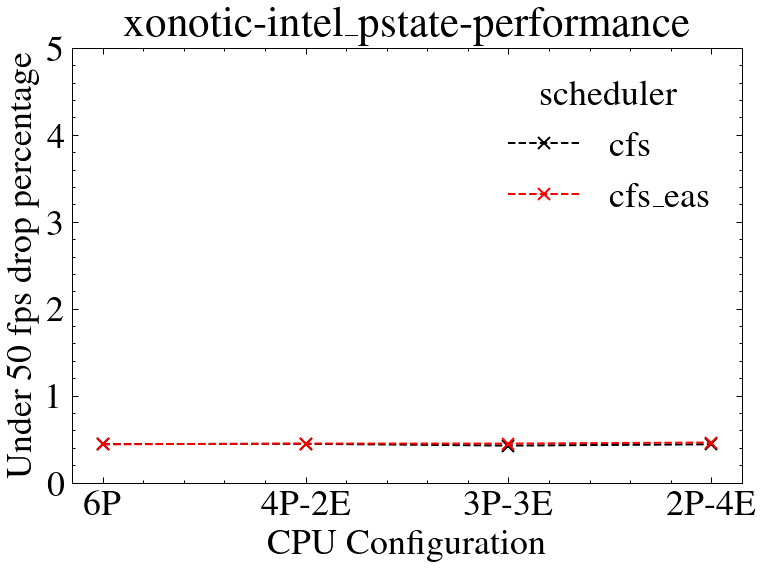

power gain
cpu_config
6P       5.504899
4P-2E    3.530707
3P-3E    4.521891
2P-4E    1.636069
dtype: float64

performance gain
cpu_config
6P       0.671001
4P-2E   -0.719151
3P-3E   -5.417857
2P-4E   -4.650112
dtype: float64


In [65]:
game = 'xonotic'
algo = 'performance'
df_ = get_df(df, game=game, algorithm=algo)


t = pd.pivot_table(df_, index=['cpu_config'], columns=['scheduler'], values=values).iloc[::-1]

t.plot.line(
    y='power_mean_watt', 
    xlabel='CPU Configuration', 
    ylabel='Consumed Power (Watts)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 15],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='median_cpuload', 
    xlabel='CPU Configuration', 
    ylabel='CPU LOAD (\%)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 30],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='fps_drop_50_percent', 
    xlabel='CPU Configuration', 
    ylabel='Under 50 fps drop percentage', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 5],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

print("power gain")
print((1 - t.power_mean_watt.cfs_eas / t.power_mean_watt.cfs)*100)
print("\nperformance gain")
print((1 - t.fps_drop_50_percent.cfs_eas / t.fps_drop_50_percent.cfs)*100)

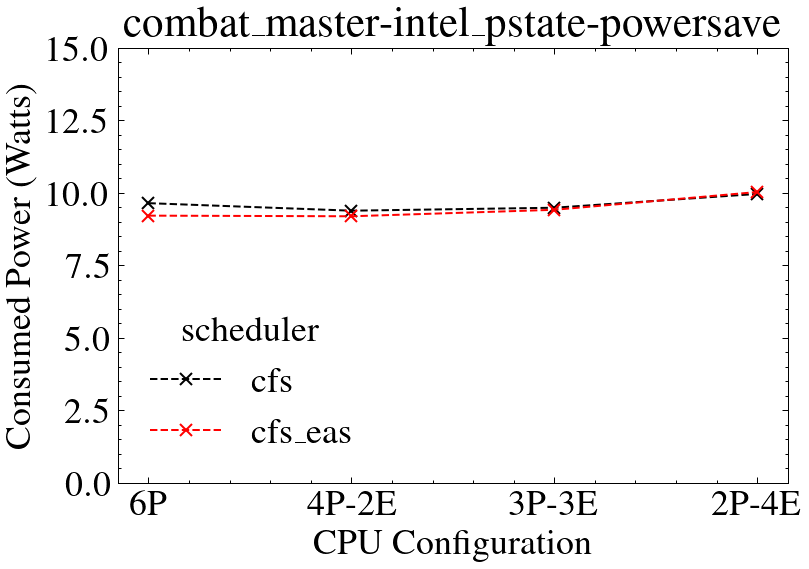

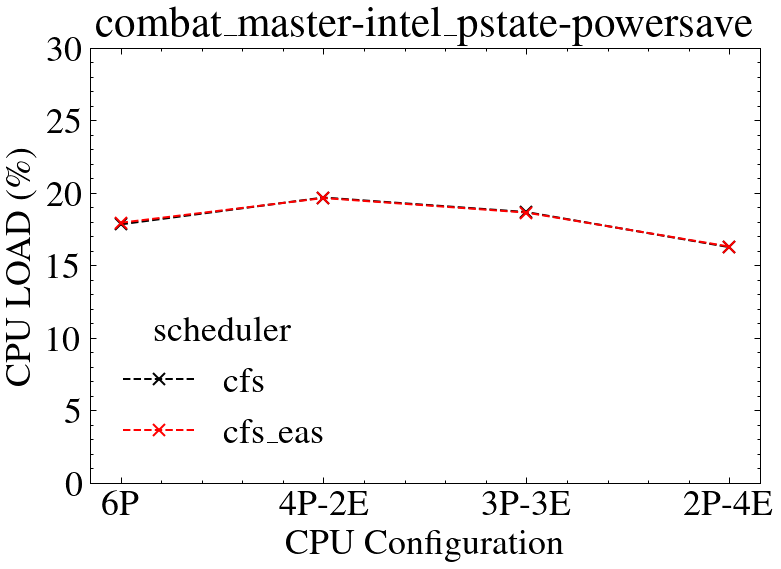

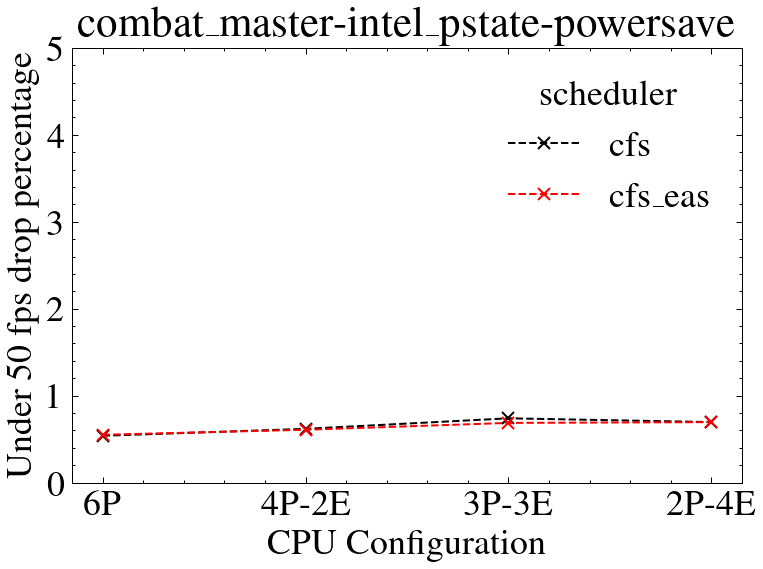

power gain
cpu_config
6P       4.467441
4P-2E    2.054925
3P-3E    0.752463
2P-4E   -0.663150
dtype: float64

performance loss
cpu_config
6P      -2.126394
4P-2E    1.727130
3P-3E    7.138855
2P-4E    0.092764
dtype: float64


In [66]:
game = 'combat_master'
algo = 'powersave'
df_ = get_df(df, game=game, algorithm=algo)


t = pd.pivot_table(df_, index=['cpu_config'], columns=['scheduler'], values=values).iloc[::-1]

t.plot.line(
    y='power_mean_watt', 
    xlabel='CPU Configuration', 
    ylabel='Consumed Power (Watts)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 15],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='median_cpuload', 
    xlabel='CPU Configuration', 
    ylabel='CPU LOAD (\%)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 30],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='fps_drop_50_percent', 
    xlabel='CPU Configuration', 
    ylabel='Under 50 fps drop percentage', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 5],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

print("power gain")
print((1 - t.power_mean_watt.cfs_eas / t.power_mean_watt.cfs)*100)
print("\nperformance loss")
print((1 - t.fps_drop_50_percent.cfs_eas / t.fps_drop_50_percent.cfs)*100)

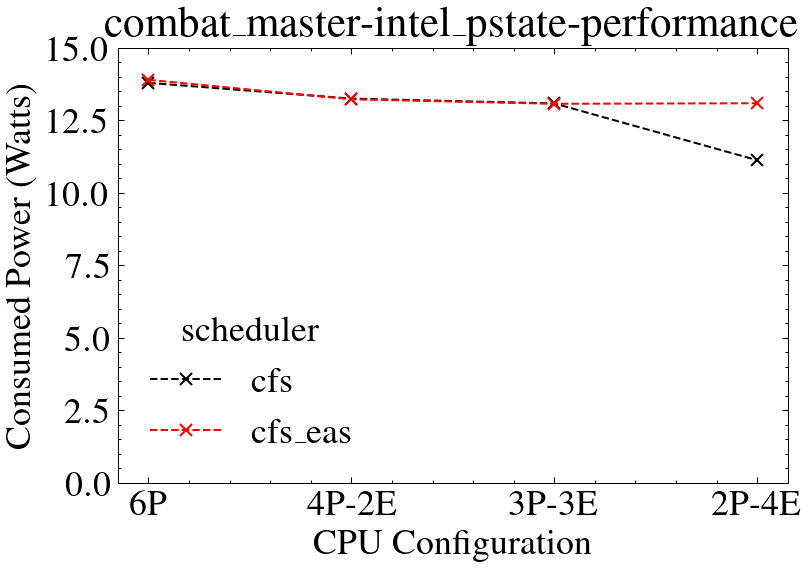

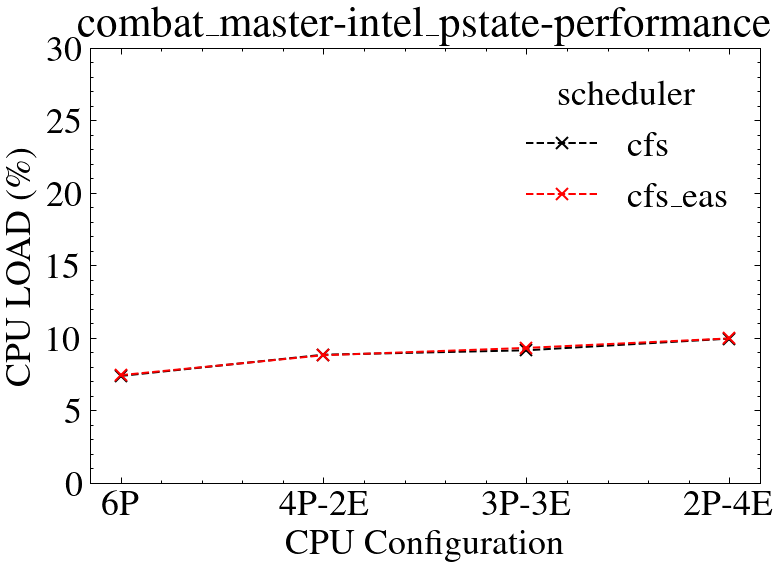

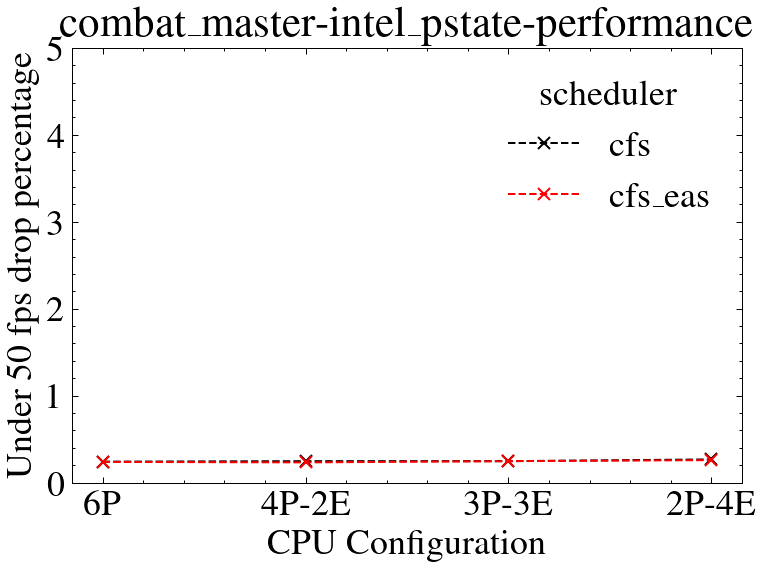

power gain
cpu_config
6P       -0.748635
4P-2E     0.191789
3P-3E     0.092044
2P-4E   -17.665841
dtype: float64

performance loss
cpu_config
6P       1.125294
4P-2E    5.806640
3P-3E    0.014155
2P-4E    3.214688
dtype: float64


In [67]:

game = 'combat_master'
algo = 'performance'
df_ = get_df(df, game=game, algorithm=algo)


t = pd.pivot_table(df_, index=['cpu_config'], columns=['scheduler'], values=values).iloc[::-1]

t.plot.line(
    y='power_mean_watt', 
    xlabel='CPU Configuration', 
    ylabel='Consumed Power (Watts)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 15],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='median_cpuload', 
    xlabel='CPU Configuration', 
    ylabel='CPU LOAD (\%)', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 30],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

t.plot.line(
    y='fps_drop_50_percent', 
    xlabel='CPU Configuration', 
    ylabel='Under 50 fps drop percentage', 
    title=f"{game}-intel_pstate-{algo}", 
    ylim=[0, 5],
    style='x--'
)
plt.xticks(rotation=0)
plt.show()

print("power gain")
print((1 - t.power_mean_watt.cfs_eas / t.power_mean_watt.cfs)*100)
print("\nperformance loss")
print((1 - t.fps_drop_50_percent.cfs_eas / t.fps_drop_50_percent.cfs)*100)